In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here

import matplotlib
import matplotlib.pyplot as plt

# import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
# import vision_pipeline.obb
# import imagesize
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
# from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
# from shapely.geometry import Polygon
from rich import print
# from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera, detections_to_ros, detections_to_py
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle

from context_action_framework.srv import VisionDetection, VisionDetectionResponse, VisionDetectionRequest, ProcessImg, ProcessImgResponse

from action_predictor.graph_relations import GraphRelations

from cv_bridge import CvBridge
import rospy


rospy.init_node("test_node")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-08-01_basler_hca_backs/0001.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_01/00_template_0039.jpg")
img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_03.1/0182.jpg")


img = cv2.imread(img_path)
img = imutils.resize(img, width=1450, height=1450)

# display(PILImage.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

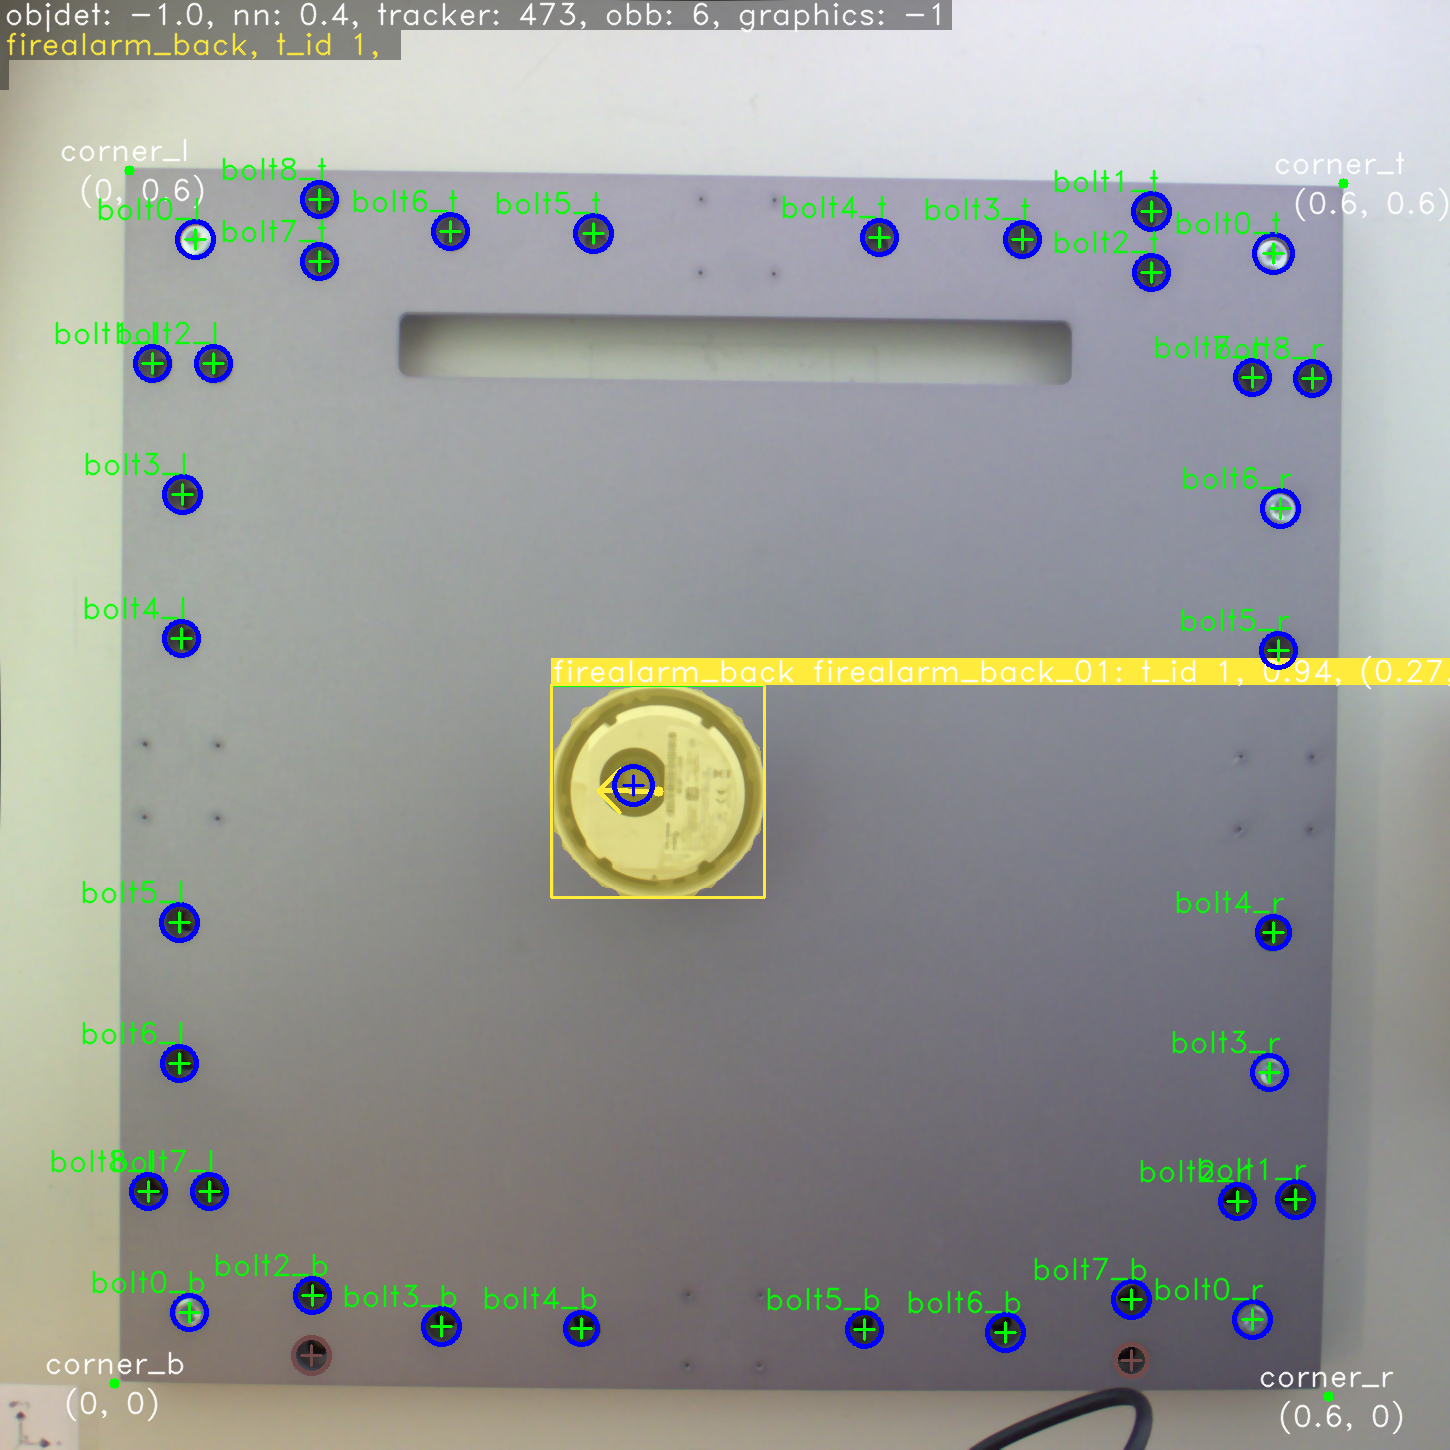

detections
[
    Detection(
        id=0,
        tracking_id=1,
        label=<Label.firealarm_back: 10>,
        label_precise='firealarm_back_01',
        score=0.9415026903152466,
        tf_px=translation: 
  x: 658.0
  y: 791.0
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: 0.9999911153068222
  w: 0.004215365632752381,
        box_px=array([[551.08209229, 684.53930664],
       [764.909729  , 897.56225586]]),
        obb_px=array([[552., 685.],
       [764., 685.],
       [764., 897.],
       [552., 897.]]),
        center_px=array([658., 791.]),
        polygon_px=<POLYGON ((634 685, 633 686, 632 686, 630 688, 624 688, 623 689, 615 689, 61...>,
        tf=translation: 
  x: 0.26522970377531024
  y: 0.29573368302871184
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: 0.9999911153068222
  w: 0.004215365632752381,
        box=array([[0.21177112, 0.34784696],
       [0.31868488, 0.24357013]]),
        obb=array([[0.2122273 , 0.3476238 ],
       [0.31693915, 0.3487263 ],
       [0.31823212, 0.24384357],
       [0.21352024, 0.24274106]]),
        center=array([0.2652297 , 0.29573369, 0.        ]),
        polygon=<POLYGON Z ((0.253 0.348 0.025, 0.252 0.348 0.025, 0.252 0.348 0.025, 0.251 ...>,
        obb_3d=array([[0.2122273 , 0.3476238 , 0.        ],
       [0.31693915, 0.3487263 , 0.        ],
       [0.31823212, 0.24384357, 0.        ],
       [0.21352024, 0.24274106, 0.        ],
       [0.2122273 , 0.3476238 , 0.025     ],
       [0.31693915, 0.3487263 , 0.025     ],
       [0.31823212, 0.24384357, 0.025     ],
       [0.21352024, 0.24274106, 0.025     ]]),
        mask=None,
        mask_contour=None,
        tracking_score=None,
        tracking_box=None
    )
]

In [12]:
def call_process_img(img):
    timeout = 3 # 2 second timeout
    rospy.wait_for_service('vision/basler/process_img', timeout)

    imgmsg = CvBridge().cv2_to_imgmsg(img, encoding="bgr8")
    try:
        process_img = rospy.ServiceProxy('vision/basler/process_img', ProcessImg)
        response = process_img(imgmsg)
        detections = detections_to_py(response.detections)
        labelled_img = CvBridge().imgmsg_to_cv2(response.labelled_image, desired_encoding='passthrough')
        
        return response.success, detections, labelled_img
        # return response
    except rospy.ServiceException as e:
        print("Service call failed: %s"%e)

success, detections, labelled_img = call_process_img(img)

display(PILImage.fromarray(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB)))

print("detections", detections)

In [7]:

# TODO: preprocess img for LLM.
# given img, return:
# - positions of objects (incl. gap)
# - relations of objects
# - which table we are on
# - precise obj recognition


success, detections, labelled_img = call_process_img(img)


graph_relations = GraphRelations(detections)

A_relations = graph_relations.to_text()


label_precise = None
positions_list = []
for detection in detections:
    if detection.label_precise != "":
        label_precise = detection.label_precise
    positions_list.append(f"{detection.label.name} at ({detection.center_px[0]}, {detection.center_px[1]})")

A_positions = ", ".join(positions_list) + ". "

print("A_relations", A_relations)
print("A_positions", A_positions)
print("label_precise", label_precise)

# todo: get specific device recognition


A_relations Device 1: internals in hca_back, battery in hca_back, battery next to internals.

A_positions hca_back at (982.0, 1158.0), internals at (985.0, 1162.0), battery at (1060.0, 1203.0).

label_precise hca_back_01

In [9]:


# def call_get_detection():
#     timeout = 3 # 2 second timeout
#     service_path = 'vision/basler/get_detection'
#     rospy.wait_for_service(service_path, timeout)

#     # imgmsg = CvBridge().cv2_to_imgmsg(img, encoding="bgr8")
#     try:
#         get_detection = rospy.ServiceProxy(service_path, VisionDetection)
#         response = get_detection(camera=Camera.basler.value, gap_detection=False)
#         return response
#     except rospy.ServiceException as e:
#         print("Service call failed: %s"%e)

# response = call_get_detection()
# print("response", response)